# Случайные процессы. Прикладной поток.
## Практическое задание 7

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 7"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## Регрессия на гауссовских процессах

Напомним задачу регрессии. Пусть имеется некоторая функциональная зависимость $y = f(x)$. Для ее оценки проводится серия испытаний в точках $x_1, ..., x_n$, в которых получаются значения $Y_i = f(x_i) + \varepsilon_i$, где $\varepsilon_i$ --- случайная ошибка измерений. Задача состоит в том, чтобы по этим наблюдениям оценить зависимость $f$. В курсе статистики мы рассматривали случай линейных функций. Теперь рассмотрим случай, когда $f$ является траекторией некоторого стационарного гауссовского процесса.

*Внимание!* Далее происходит смена обозначений на принятые в случайных процессах. Буква $x$ меняется на $t$, а буква $y$ меняется на $x$.

Пусть $X = (X_t, t \in \mathbb{R})$ --- стационарный гауссовский процесс с нулевой функцией среднего и ковариационной функцией $R(t) = cov(X_t, X_0)$. Даны его измерения $x_1, ..., x_n$ в моменты времени $t_1, ..., t_n$ соответственно. Тогда условное распределение $X_t$ при условии $X_{t_1} = x_1, ..., X_{t_n} = x_n$ является нормальным со средним $r^TC^{-1}\overrightarrow{x}$ и дисперсией $R(0) - r^TC^{-1}r$, где $C=\left(R(t_i - t_j)\right)_{i,j}$, $r=\left(R(t - t_1), ..., R(t - t_n)\right)^T$, $\overrightarrow{x}=\left(x_1, ..., x_n\right)^T$.


Байесовской оценкой общего вида значения процесса в момент времени $t$ является условное распределение $X_t$ при условии $...$.
В качестве точечной оценки обычно берут условное математическое ожидание $\mathsf{E}\left(X_t \left| X_{t_1} = x_1,\ ...,\ X_{t_n} = x_n \right. \right)$.
Кроме того, для каждого $t$ можно построить доверительный интервал для величины $X_t$, зная условную дисперсию.

Предположим, что для каждого $t$ построен доверительный интервал для $X_t$ уровня доверия 0.95. Верно ли, что $\mathsf{P}(\exists t: \text{истинное значение $X_t$ не попало в свой доверительный интервал}) \leqslant 0.05$?

**Ответ: ** Нет, это не так.  
Приведем пример. Рассмотрим функцию ковариации $R(t) = I\{t = 0\}$. Тогда величины $X_{t_{i}}$ и $X_{t_{j}}$ будут независимы $(i \ne j)$. Допустим, что для них пострены доверительные интервалы $(a_{i}, b_{i})$ и $(a_{j}, b_{j})$ соответственно. Тогда
$$\mathsf{P}(\exists t: \text{истинное значение $X_t$ не попало в свой доверительный интервал}) \ge$$
$$\mathsf{P}(X_{i} \not\in (a_{i}, b_{i}) \vee X_{j} \not\in (a_{j}, b_{j})) =$$
$$\left|\text{independent}\right| = 1 - \mathsf{P}(X_{i} \not\in (a_{i}, b_{i}))\cdot\mathsf{P}(X_{j} \not\in (a_{j}, b_{j})) = $$
$$\left|\text{confidence interval}\right| = 1 - 0.95^{2} = 0.0975 \ge 0.05$$

Напишите класс регрессии на гауссовских процессах.
Интерфейс похож на интерфейс библиотеки `scikit-learn`.

Наш класс будет работать для времени из $\mathbb{R}^d$, а не $\mathbb{R}$.
Почему так можно сделать на основе решенной задачи?

**Ответ: ** Кажется, что нигде выше явно не использовалось, что время является одномерным. Просто теперь ковариационная функция будет принимать $d$ аргументов - размерность времени.

При написании класса пользуйтесь `numpy.matrix` для работы с матрицами, либо операцией `@` для объектов `numpy.array`.

In [2]:
class GaussianProcessRegression:
    
    def __init__(self, cov_function):
        self.cov_function = cov_function
    
    
    def fit(self, T, X):
        ''' "Обучение" модели регрессии.
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые проведены измерения
                X --- np.array, размерность n: полученные значения процесса
        '''
        
        self.T = T
        self.X = X
        A = np.array([T] * len(T))
        B = np.array([T.T] * len(T))
        B = np.reshape(B.T, (len(T), len(T), len(T[0])))
        self.C = (self.cov_function(A - B)).T
        
        return self
        
        
    def predict(self, T):
        ''' Оценка значения процесса. 
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые нужно оценить значения. 
                
            Возвращает:
                values --- np.array, размерность n: предсказанные 
                           значения процесса
                sigma --- np.array, размерность n: соответствующая дисперсия
        '''
        
        A = np.array([T] * len(self.T))
        B = np.array([self.T.T] * len(T))
        B = np.reshape(B.T, (len(self.T), len(T), len(self.T[0])))
        
        r = (self.cov_function(A - B))
        values = r.T @ np.linalg.inv(self.C) @ self.X.T
        sigma = (self.cov_function(np.array([0])) - r.T @ np.linalg.inv(self.C) @ r).diagonal()
        
        return values, sigma

Зададим какую-нибудь простую функцию $f(t)$

In [3]:
def calc_f(t, a=0.2, b=0.5, c=2):
    return np.log(1 + t) + a * t + b * np.sin(c * t)

И ковариационную функцию
$$R(t) = a\ exp\left(\frac{\left|\left| t \right|\right|^2} {2s^2} \right),$$

* $t \in \mathbb{R}^d$
* $a, s > 0$ --- параметры

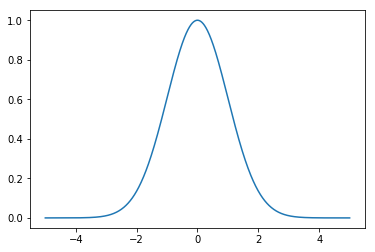

In [4]:
def exp_cov(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2))

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

Проведем эксперименты.
Зададим гауссовский процесс $(X_t, t\in\mathbb{R})$ в виде $X_t = f(t) + \sigma\varepsilon_t$, где $(\varepsilon_t, t\in\mathbb{R})$ --- гауссовский белый шум, то есть все $\varepsilon_t$ независимы и имеют стандартное нормальное распределение.

В качестве моментов времени $t_1, ..., t_n$ гененируем несколько точек на прямой.
Для начала возьмем $\sigma=0$, что соответствует отсутствию погрешности измерений.
Выполните код ниже.

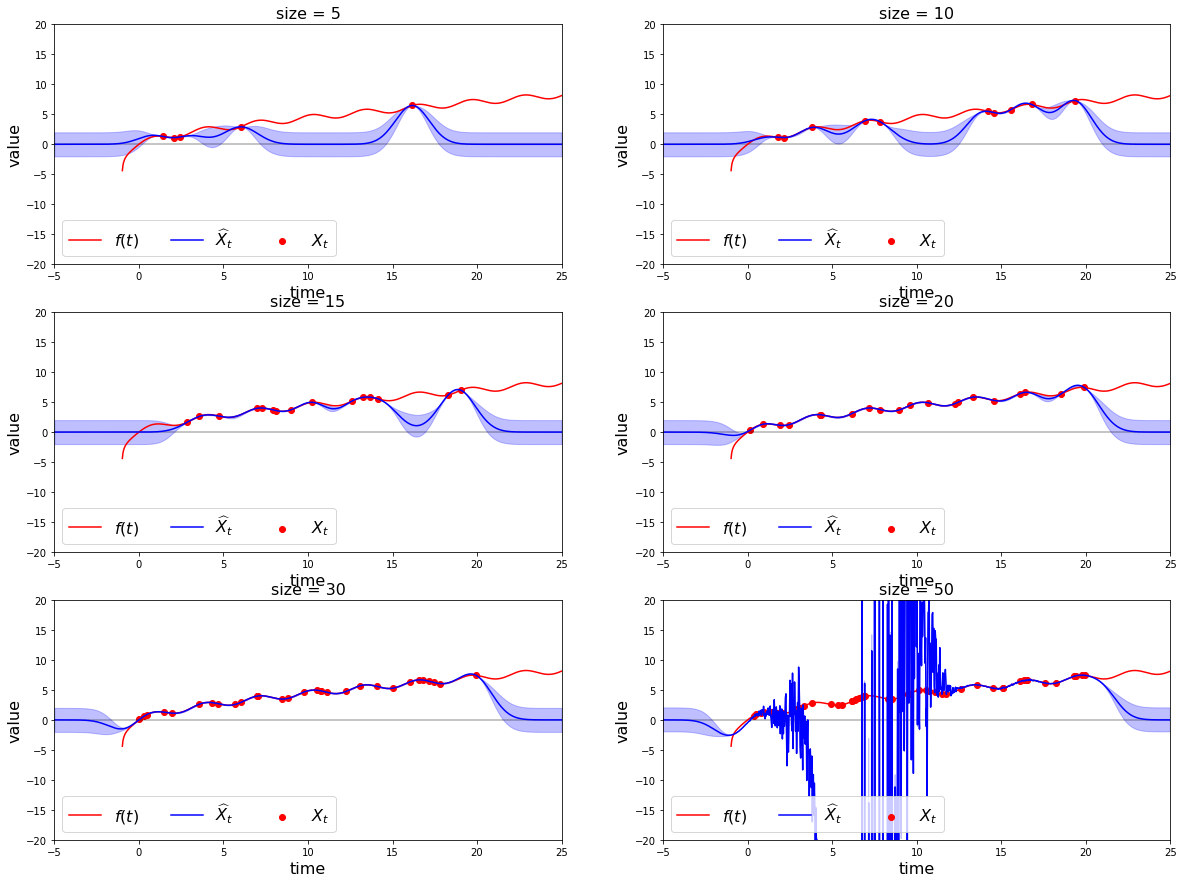

In [5]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = sps.uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Теперь предположим, что измерения проводятся с погрешностью, то есть $\sigma > 0$. Скопируйте код выше в новую ячейку, раскомментируйте строчку кода и запустите.

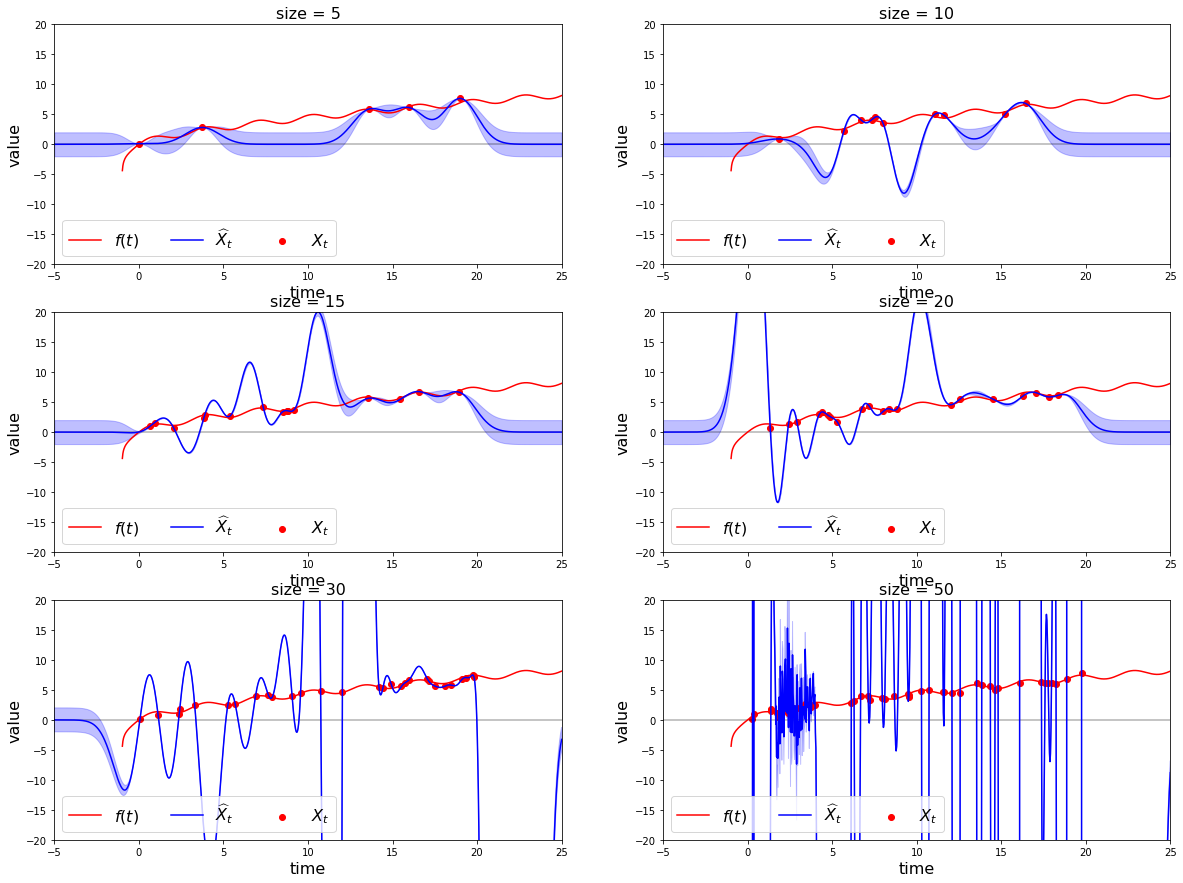

In [6]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = sps.uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += sps.norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему получается так плохо? Что нужно сделать, чтобы это исправить (обратите внимание на ковариационную функцию)?

**Ответ:** Функция $R(t)$ является непрерывной в нуле $\implies E(X_{t_{i}}|X_{t_{1}},\ldots,X_{t_{n}}) = x_{i}$. Иными словами, предсказанная кривая должна проходить через все обучающие точки. Когда их становится много, то ошибки (шум), приводит к ужасному искажению кривой. Если говорить не очень формально, то в таком случае значения в близкие моменты времени считаются сильно зависимыми.  
На семинаре был предложен такой способ исправления: вместо функции $R(t)$ рассмотреть функцию $R(t) + D_{0}I\{t=0\}$. Она уже не является непрерывной в нуле $\implies$ построенная кривая не обязана проходить через точки обучающей выборки (но все равно будет проходить близко к ним). 

Исправьте это.

На семинаре в качестве $D_{0}$ брали и 1, и 10. Ну я взял 0.3 (от этого будет зависеть ширина доверительного интервала). Кажется, ничего плохо.

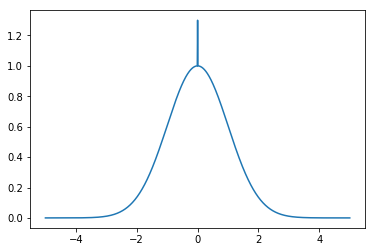

In [7]:
def exp_cov(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2)) + ((t==0).prod(axis=-1) * 0.3)

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

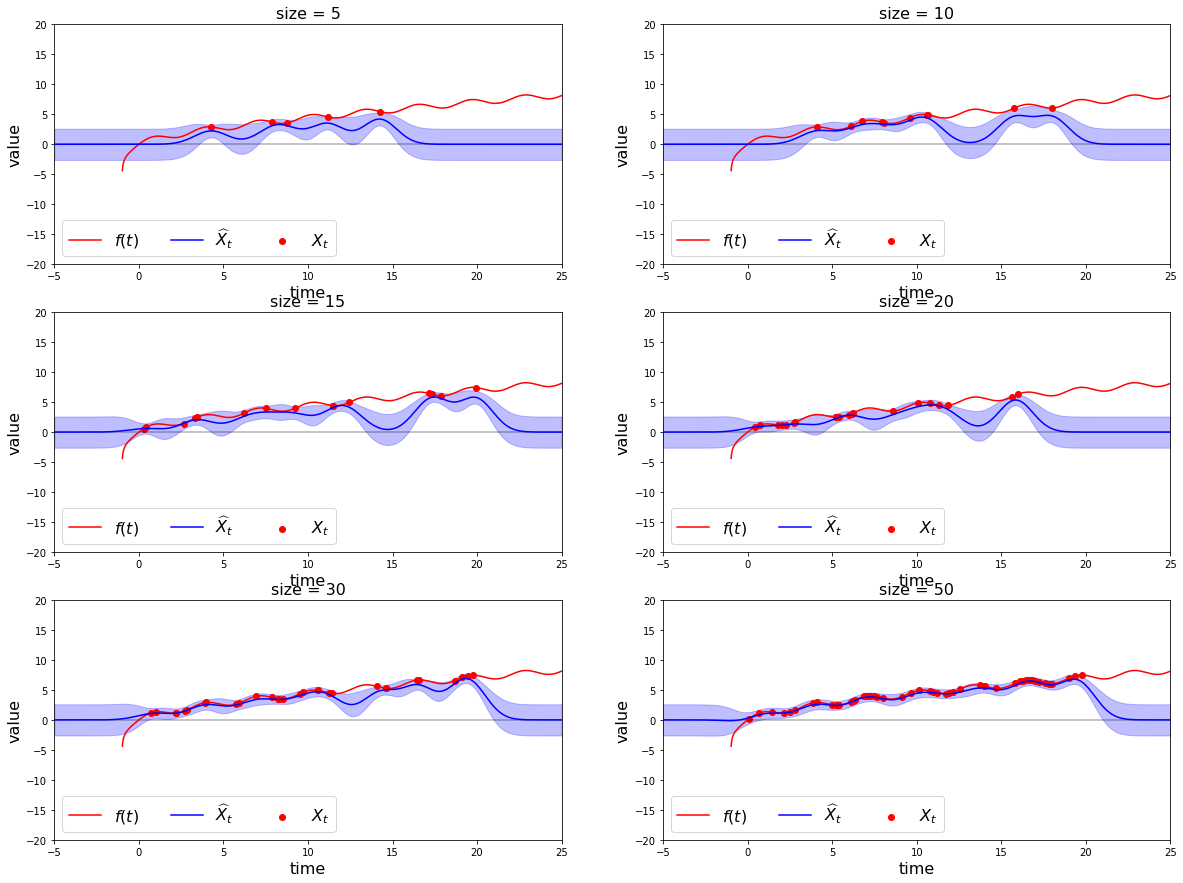

In [8]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = sps.uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
#     X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

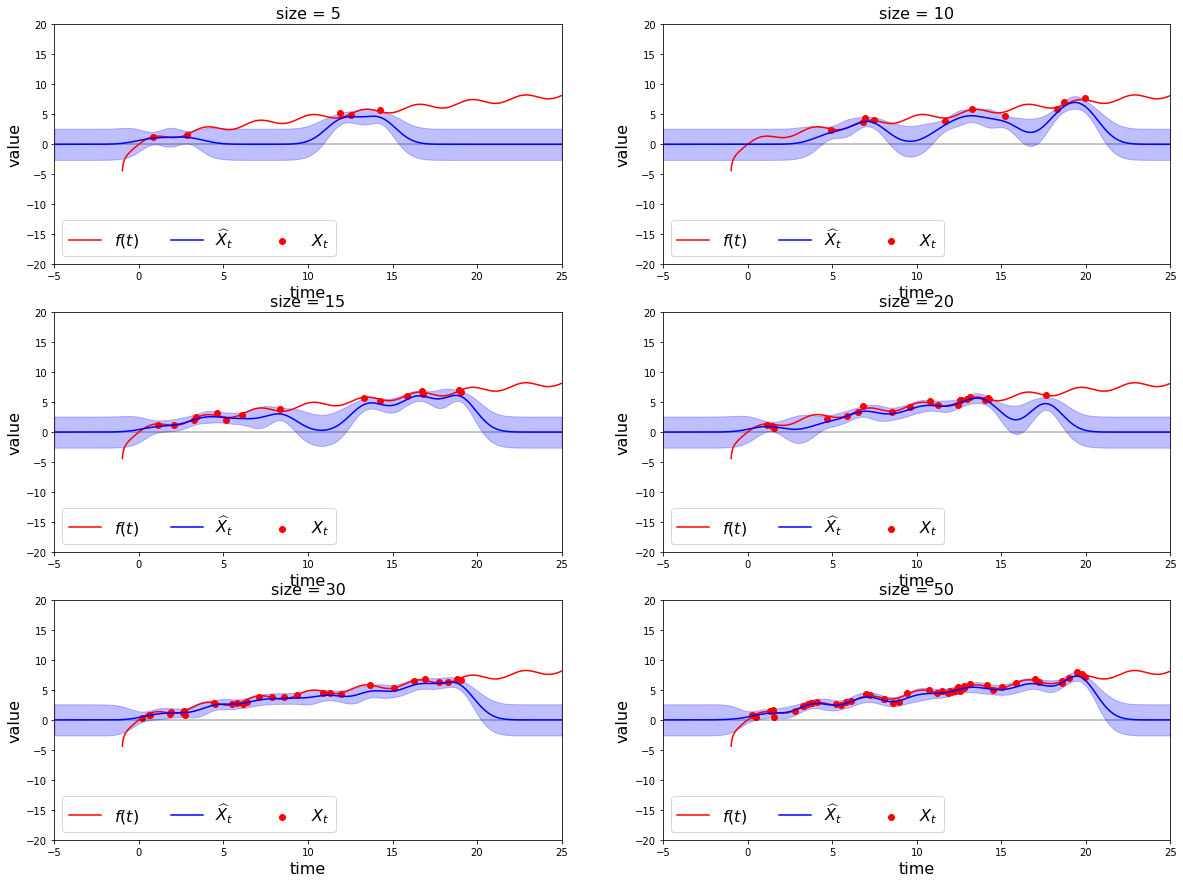

In [9]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = sps.uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += sps.norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему стало лучше?

**Ответ: ** Как уже было отмечено ранее, ковариационная функция теперь не является непрерывной в нуле. Теперь построенная кривая не обязана проходить строго через точки обучающей выборки.

Однако, это все равно не поясняет, почему в самом первом случае (при $\sigma=0$) мог наблюдаться похожий эффект. В чем его причина?

**Ответ: ** Раньше значения были очень маленькими. Возможно, происходили какие-то проблемы, связанные с точностью вычислений. После изменения функции какие-то элементы могли поменяться (увеличиться на $D_{0}$), в связи с чем значения были бы уже не такими маленькими.

In [10]:
def exp_cov_bad(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2))

T = sps.uniform(loc=0, scale=20).rvs(size=20).reshape((20, 1))
bad = exp_cov_bad(T)
print(bad)

[  1.48648102e-33   2.57180083e-15   7.63898177e-09   2.74665623e-67
   6.36999082e-02   2.81699668e-74   1.26370433e-02   5.75732285e-41
   1.65332213e-54   6.87751072e-69   2.01870240e-02   3.07210254e-34
   4.51433640e-56   1.79183510e-22   2.19255823e-73   3.39048657e-02
   2.32986320e-01   7.61819046e-82   4.46519407e-56   1.16336688e-06]


Пойдем теперь дальше. Вспомним наше предположение о том, что математическое ожидание равно нулю, хотя на самом деле это не так.
Давайте это исправим.
В примере выше перед применением регрессии вычтете среднее значение, а после --- добавьте обратно.

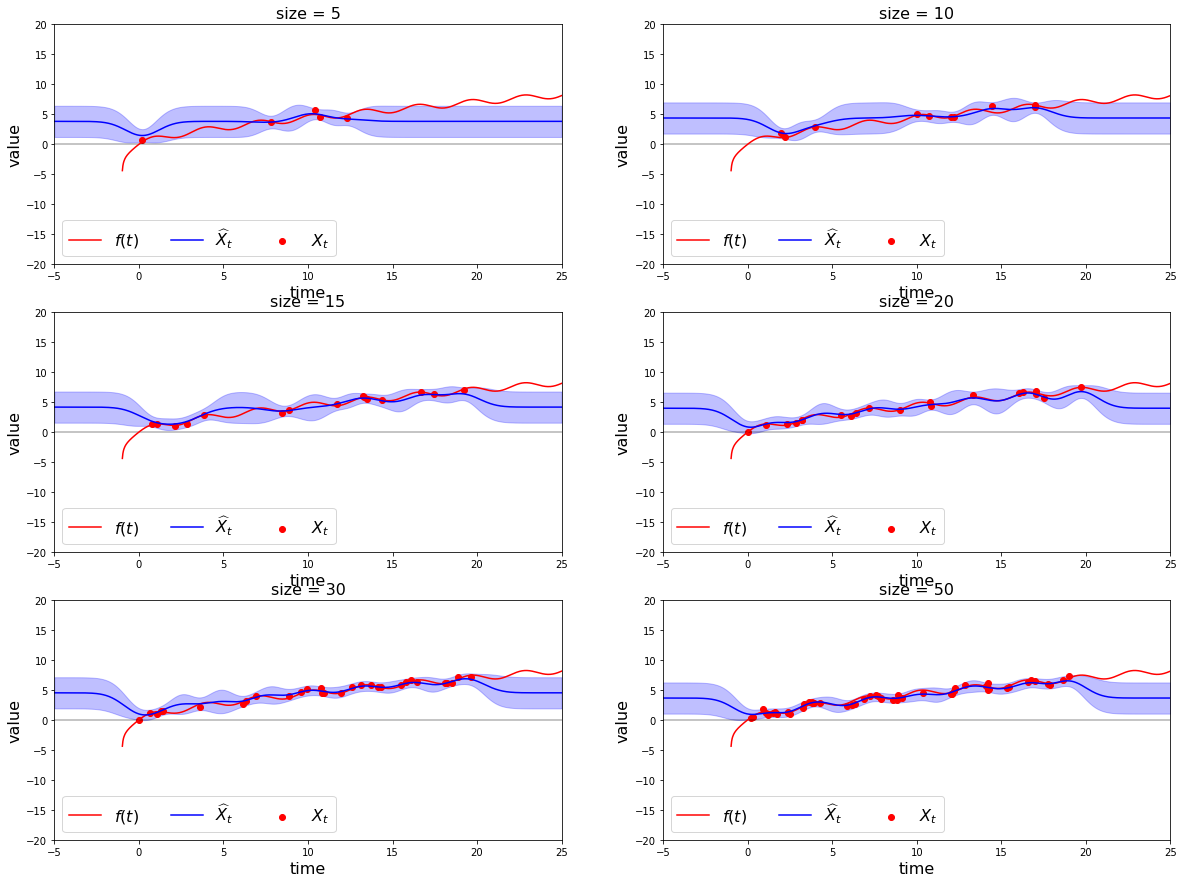

In [11]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = sps.uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    X += sps.norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    # Среднее сразу вычитается из X и передается в fit
    # Так не придется потом добавлять его обратно
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - np.mean(X))
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Прибавление среднего значения
    predict += np.mean(X)
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Лучше, но все равно чего-то не хватает.
Может, приблизить линейной регрессией?

Проделайте аналогичные действия, построив сначала линейную регрессию, затем вычев ее значения из точек данных перед применением регрессии на гауссовских процессах, а после --- добавив обратно значения линейной регрессии для всех точек, в которых вы хотите построить предсказания.

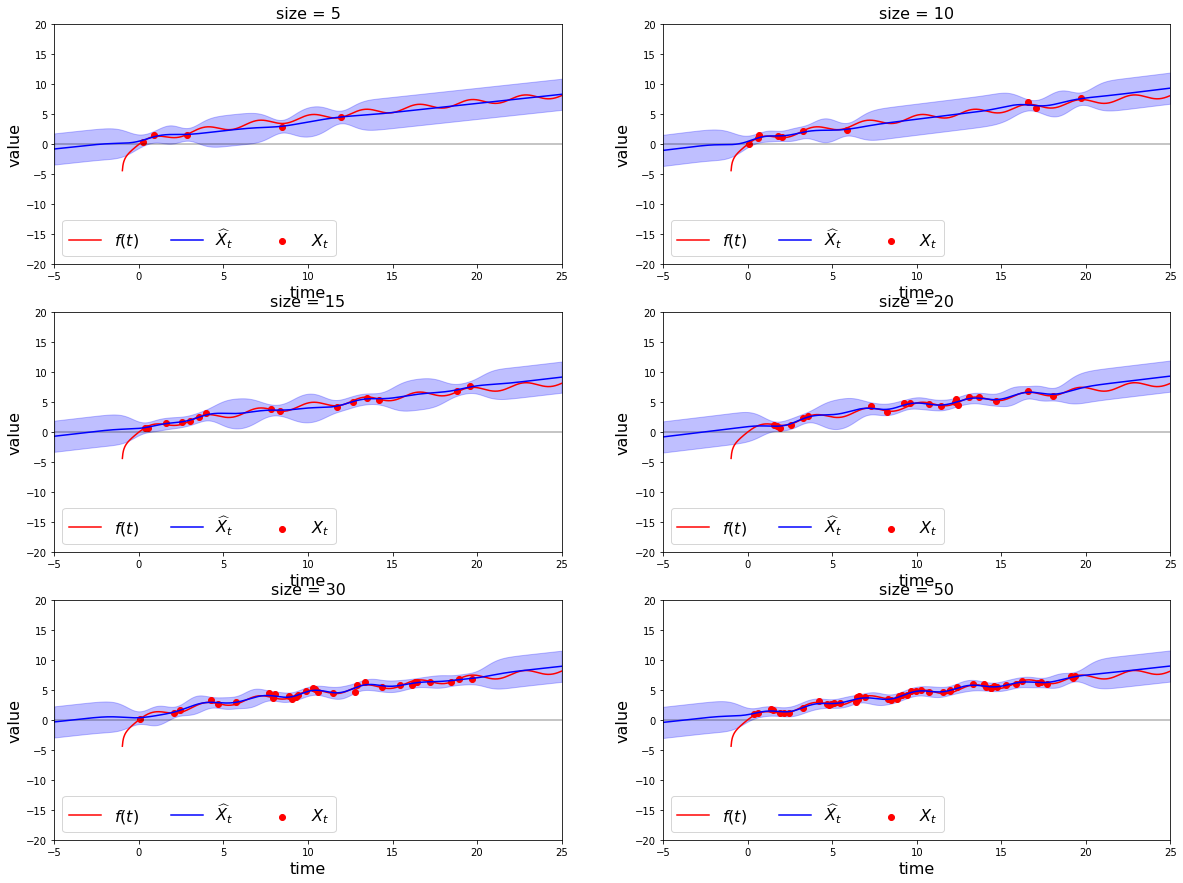

In [12]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = sps.uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    X += sps.norm(0, 0.3).rvs(X.shape)

    # Линейная регрессия
    Q = T.reshape((size, 1))
    W = np.reshape(np.ones(size), (size, 1))
    A = np.hstack((Q, W))
    params = np.linalg.inv(A.T @ A) @ A.T @ X    
    additionaltest = params[0] * T + params[1]
    additionaltrain = params[0] * grid + params[1]
    
    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - additionaltest)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Прибавление
    predict += additionaltrain
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Разберемся подробнее в том, что происходит.

Допустим, мы хотим приблизить простую линейную функцию.
Построим график выборки и график предсказаний с помощью линейной регрессии.
Построим так же график ошибок, то есть точек $X_{t_i} - \widehat{f}(t_i)$, где $\widehat{f}$ --- линейная регрессия.

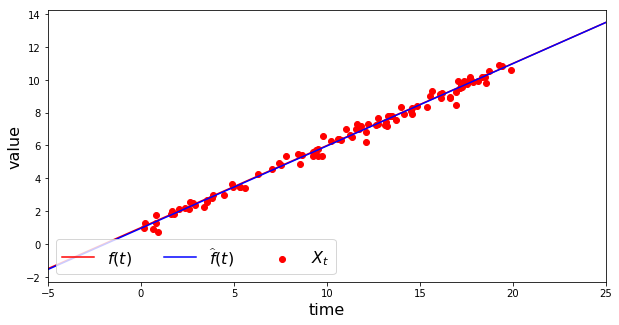

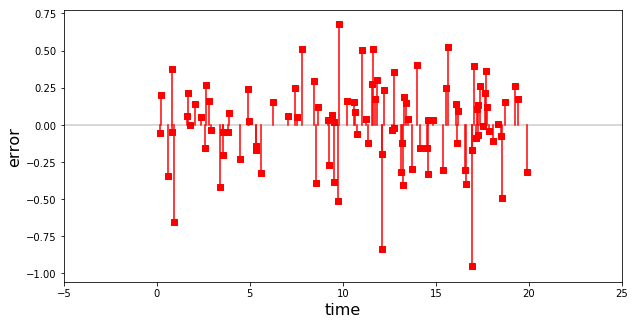

In [13]:
def f_lin(x):
    return x / 2 + 1

T = sps.uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = f_lin(T)
X += sps.norm(0, 0.3).rvs(X.shape)

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))

# Линейная регрессия
Q = T.reshape((100, 1))
W = np.reshape(np.ones(100), (100, 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ X
predict = params[0] * grid + params[1]

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, f_lin(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - params[0] * T[i] - params[1]], color='red')
    plt.scatter(T[i], X[i] - params[0] * T[i] - params[1], marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что можно сказать про остатки?

**Ответ: ** 
* Кажется, что в остатках есть некая периодичность - некоторые куски графика похожи между собой. 
* Значения ошибок не очень большие.

Теперь посмотрим на функцию, с которой мы имели дело ранее.

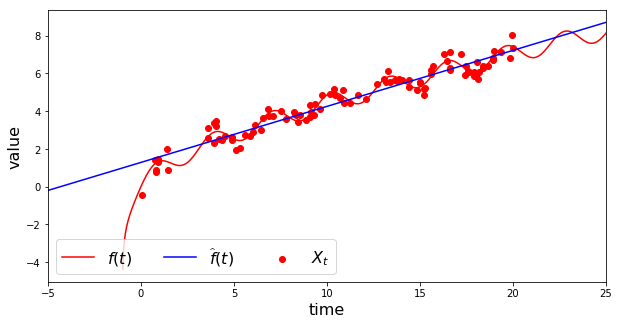

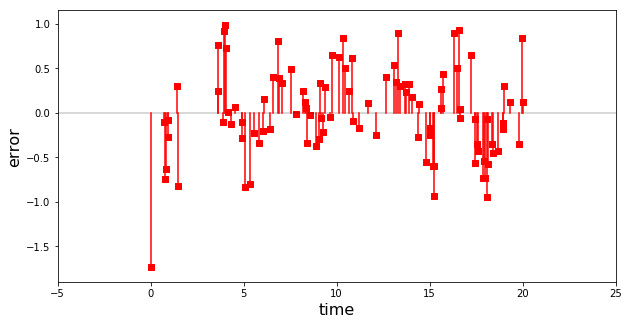

In [14]:
T = sps.uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = calc_f(T)
X += sps.norm(0, 0.3).rvs(X.shape)

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))

# Линейная регрессия
Q = T.reshape((100, 1))
W = np.reshape(np.ones(100), (100, 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ X
predict = params[0] * grid + params[1]

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - params[0] * T[i] - params[1]], color='red')
    plt.scatter(T[i], X[i] - params[0] * T[i] - params[1], marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что тут с остатками?

**Ответ: **
* Значения ошибки тоже не сильно велики. Это наталкивает на мысль, что регрессию можно применять и к нашей функции.
* Периодичность в ошибках также прослеживается. 

Давайте приближать эту зависимость в остатках регрессией на основе гауссовских процессах.

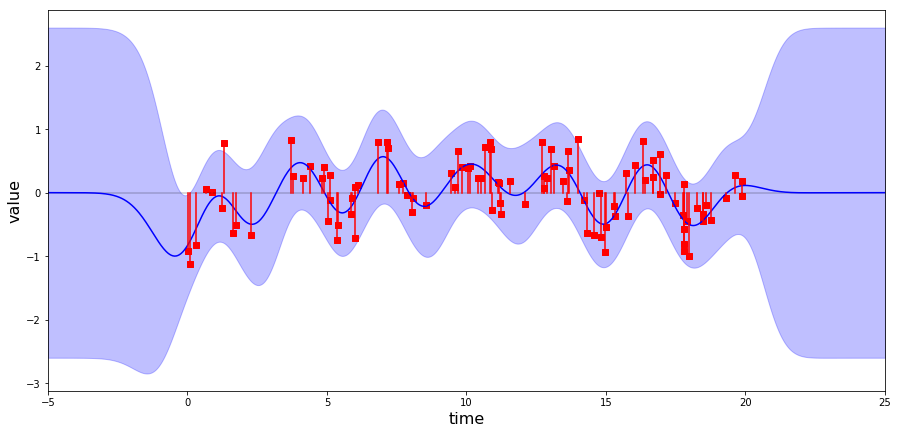

In [15]:
T = sps.uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = calc_f(T)
X += sps.norm(0, 0.3).rvs(X.shape)

Q = T.reshape((100, 1))
W = np.reshape(np.ones(100), (100, 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ X
Y = X - params[0] * T - params[1]

gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), Y[:, 0])
grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
predict, sigma = gpr.predict(grid)
grid, predict, sigma = np.array(grid).ravel(), predict, sigma

plt.figure(figsize=(15, 7))
plt.plot(grid, predict, color='blue')
plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                 color='blue', alpha=0.25)
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - params[0] * T[i] - params[1]], color='red')
    plt.scatter(T[i], X[i] - params[0] * T[i] - params[1], marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.show()

Сделайте подробные выводы.

**Вывод: **
* Линейная регрессия стремится разделить данные на две части: выше и ниже кривой. Если точки часто переходят из одной части в другую, то на графике ошибок будет наблюдаться переодичность.
* Такая же тенденция будет и при использовании регрессии на гауссовских процессах.
* Это наталкивает на мысль о комбинировании этих двух подходов.
* Если посмотреть на последний график, то становится понятно, что это идея является хорошей.

Рассмотрим теперь гауссовский процесс $(X_t, t\in\mathbb{R}_+)$, заданный как $X_t = t + W_{t+1} - W_{t}$, где $(W_t, t\in\mathbb{R}_+)$ --- винеровский процесс.
Сгенерируйте данные в соответствии с этой моделью. Для генерации винеровского процесса используйте код из предыдущего задания. По этим данным постройте комбинацию линейная регрессия + регрессия на гауссовских процессах, как в примерах выше. Как и раньше, проведите эксперимент для различного объема данных.

In [16]:
class WinerProcess:
    def __init__(self, precision=10000):
        #Все обозначения согласно книге Булинского и Ширяева
        self.precision = precision
        self.xi = [sps.norm.rvs(size=precision)]
        self.n = np.log2(np.arange(1, precision)).astype(int)
        #Часто приходится считать величины вида 2^k (причем и в цикле по времени тоже)
        #Поэтому был сделан их предподсчет
        self.power = np.power(2, self.n)
        self.powerp1 = np.power(2, self.n + 1)
        self.powerhalf = np.power(2, self.n / 2 + 1)
        self.a_nk = (np.arange(1, precision) - self.power) / self.power
        
    def __getitem__(self, times):
        W = np.array([])
        #Определяем, сколько отрезков длины 1 надо рассмотреть
        last_time = np.max(times)
        if (last_time - int(last_time) > 0):
            last_time = int(last_time) + 1
        else:
            last_time = last_time.astype(int) + 1
        #Завершаем генерацию случайных величин для всех отрезков
        y = sps.norm.rvs(size=(last_time - len(self.xi), self.precision))
        self.xi += list(y)
        #Массив правых концов
        self.rights = np.cumsum(np.array(self.xi)[:,0])
        for i in range(len(times)):
            integer = int(times[i])
            fraction = times[i] - int(times[i])
            S = np.zeros(self.precision - 1)
            #Определяем, где был подъем, а где - спуск
            positive_slope = np.logical_and(fraction <= (self.a_nk + (1 / self.powerp1)),
                                            self.a_nk <= fraction)
            negative_slope = np.logical_and(fraction <= (self.a_nk + (1 / self.power)),
                                            (self.a_nk + (1 / self.powerp1)) < fraction)
            #Считаем значения в зависимости от того, куда попала точка
            S[positive_slope] = ((fraction - self.a_nk[positive_slope]) * self.powerp1[positive_slope]) /\
                                 self.powerhalf[positive_slope]
            S[negative_slope] = (self.a_nk[negative_slope] + (1 / self.power[negative_slope]) - fraction)/\
                                ((1 / self.powerp1[negative_slope]) * self.powerhalf[negative_slope])
            S = np.insert(S, 0, fraction)
            if (integer > 0):
                W = np.append(W, self.rights[integer - 1] + S @ self.xi[integer].T)
            else:
                W = np.append(W, S @ self.xi[integer].T)
        return W

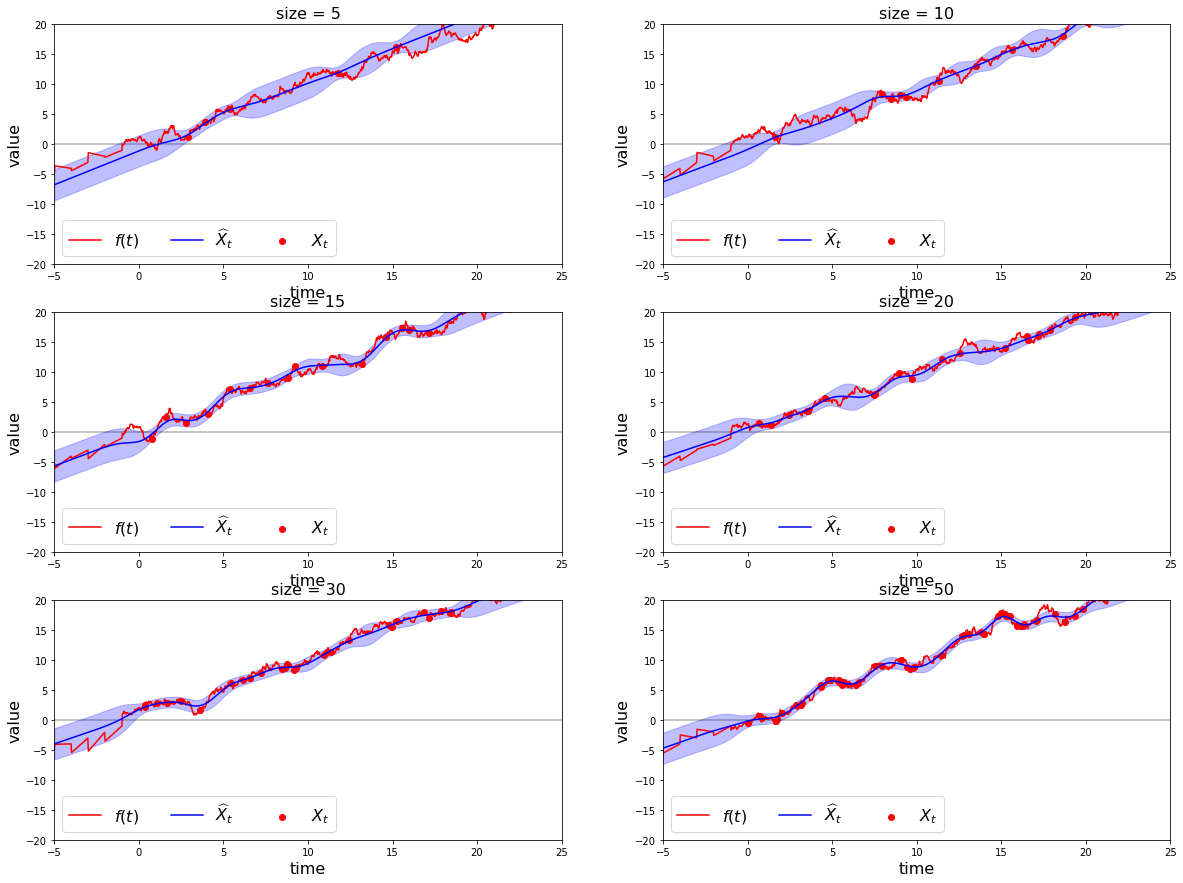

In [17]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):
    grid = np.linspace(-5, 25, 1000)
    gridp1 = grid + 1
    
    # Генерация данных
    p = WinerProcess()
    T = np.array(sorted(sps.uniform(loc=0, scale=20).rvs(size=size)))
    Tp1 = T + 1
    a = p[T]
    b = p[Tp1]
    w = p[grid]
    ww = p[gridp1]
    X = T + b - a

    # Линейная регрессия
    Q = T.reshape((size, 1))
    W = np.reshape(np.ones(size), (size, 1))
    A = np.hstack((Q, W))
    params = np.linalg.inv(A.T @ A) @ A.T @ X    
    test = params[0] * T + params[1]
    train = params[0] * grid + params[1]
    
    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - test)
    grid = grid.reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Прибавление
    predict += train
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, grid + ww - w, color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

**Вывод: **
* Во-первых, очевидно, что линейная регрессия плохо бы апроксимировала данный процесс (даже если считать, что функция не линейная, а является полиномом)
* Во-вторых, из графиков видно, что комбинация линейной регрессии и регрессии на гауссовских процессах отлично справляется с задачей.

Скачайте датасет <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a>.
Задача состоит в том, чтобы для парусных яхт предсказать остаточное сопротивление на единицу массы смещения от размеров яхты и ее скорости. Рассмотрим зависимость величины `Residuary resistance` от `Froude number`. Постройте приближение этой зависимости с помощью комбинации линейной регрессии и регрессии на гауссовских процессах. Посчитайте ошибку предсказания и сравните ее с ошибкой предсказания с помощью простой линейной регрессии. Для линейной регрессии можно взять так же вторую и третью степень величины `Residuary resistance`.

In [18]:
columns = ['Longitudinal position of the center of buoyancy',
           'Prismatic coefficient', 'Length-displacement ratio',
           'Beam-draught ratio', 'Length-beam ratio', 'Froude number',
           'Residuary resistance per unit weight of displacement']
df = pd.read_table("http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",
              sep="\s+", header=None, names=columns)

In [19]:
df.head(5)

,Longitudinal position of the center of buoyancy,Prismatic coefficient,Length-displacement ratio,Beam-draught ratio,Length-beam ratio,Froude number,Residuary resistance per unit weight of displacement
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


* В столбце $Froude\ number$ очень много повторяющихся значений. Если это не поправить, то матрица $C$ получится необратимой и посчитать ничего не получится. Для того, чтобы что-то посчитать, было решено взять только уникальные значения во $Froude\ number$, соответствующие им значения $Resistance$ усреднить.
* Подберем параметры ковариационной функции так, график предсказанных значений проходил через усредненные истинные.

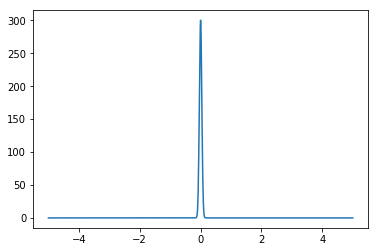

In [20]:
def exp_cov(t, a=300, s=0.04):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2)) + ((t==0).prod(axis=-1) * 0.1)

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

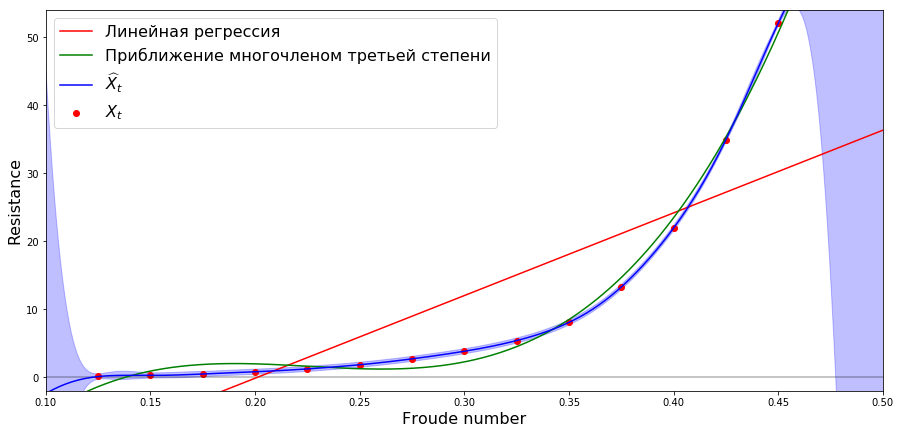

In [21]:
# Работа с данными
T = np.array(df['Froude number'])
X = np.array(df['Residuary resistance per unit weight of displacement'])

# Создание обучающей выборки
D = np.unique(T)
C = np.zeros(len(D))
for i in range(len(D)):
    for j in range(len(T)):
        if (j % len(D)) == i:
            C[i] += X[j]
C = C * len(D) / len(T)

grid = np.linspace(0, 1, 1000)

# Линейная регрессия
Q = D.reshape((len(D), 1))
W = np.reshape(np.ones(len(D)), (len(D), 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ C
test = params[0] * grid + params[1]
train = params[0] * D + params[1]

# Приближение многочленом третьей степени
QQ = D.reshape((len(D), 1))
WW = np.reshape(np.ones(len(D)), (len(D), 1))
AA = np.hstack((QQ ** 3, QQ ** 2, QQ, WW))
params = np.linalg.inv(AA.T @ AA) @ AA.T @ C
trainpoly = params[0] * (D ** 3) + params[1] * (D ** 2) +\
            params[2] * D + params[3]
testpoly = params[0] * (grid ** 3) + params[1] * (grid ** 2) +\
           params[2] * grid + params[3]


# Регрессия на гауссовских процессах
gpr = GaussianProcessRegression(exp_cov).fit(D.reshape((-1, 1)), C - train)
grid = np.linspace(0, 1, 1000).reshape((-1, 1))
predict, sigma = gpr.predict(grid)
grid, predict, sigma = np.array(grid).ravel(), predict, sigma

# Восстановление корректных значений
predict += test

plt.figure(figsize=(15, 7))
plt.plot(grid, test, color='red', label='Линейная регрессия')
plt.plot(grid, testpoly, color='green', label='Приближение многочленом третьей степени')
plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                 color='blue', alpha=0.25)
plt.scatter(D, C, color='red', label='$X_t$')
plt.hlines(0, -5, 25, alpha=0.3)
plt.xlim((0.1, 0.5))
plt.ylim((-2, 54))
plt.ylabel('Resistance', fontsize=16)
plt.xlabel('Froude number', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.show()

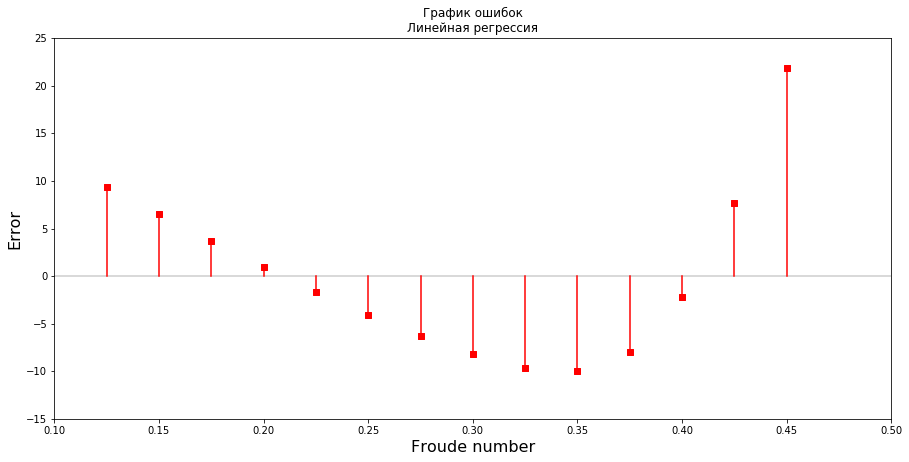

In [22]:
T = np.array(df['Froude number'])
X = np.array(df['Residuary resistance per unit weight of displacement'])

D = np.unique(T)
C = np.zeros(len(D))
for i in range(len(D)):
    for j in range(len(T)):
        if (j % len(D)) == i:
            C[i] += X[j]
C = C * len(D) / len(T)

Q = D.reshape((len(D), 1))
W = np.reshape(np.ones(len(D)), (len(D), 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ C
test = params[0] * grid + params[1]
train = params[0] * D + params[1]

predict += test

plt.figure(figsize=(15, 7))
for i in range(len(D)):
    plt.plot([D[i], D[i]], [0, C[i] - params[0] * D[i] - params[1]], color='red')
    plt.scatter(D[i], C[i] - params[0] * D[i] - params[1], marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((0.1, 0.5))
plt.ylim((-15, 25))
plt.title('График ошибок\nЛинейная регрессия')
plt.xlabel('Froude number', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.show()

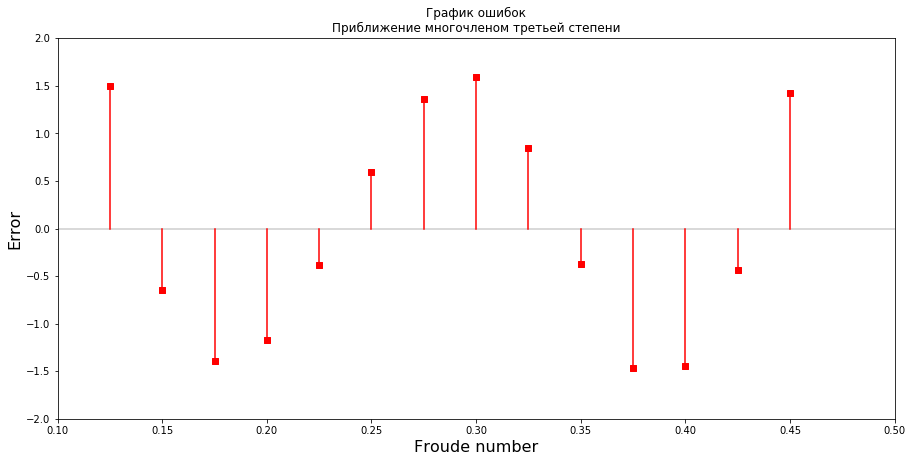

In [23]:
T = np.array(df['Froude number'])
X = np.array(df['Residuary resistance per unit weight of displacement'])

D = np.unique(T)
C = np.zeros(len(D))
for i in range(len(D)):
    for j in range(len(T)):
        if (j % len(D)) == i:
            C[i] += X[j]
C = C * len(D) / len(T)

QQ = D.reshape((len(D), 1))
WW = np.reshape(np.ones(len(D)), (len(D), 1))
AA = np.hstack((QQ ** 3, QQ ** 2, QQ, WW))
params = np.linalg.inv(AA.T @ AA) @ AA.T @ C
trainpoly = params[0] * (D ** 3) + params[1] * (D ** 2) +\
            params[2] * D + params[3]
testpoly = params[0] * (grid ** 3) + params[1] * (grid ** 2) +\
           params[2] * grid + params[3]

predict += test

plt.figure(figsize=(15, 7))
for i in range(len(D)):
    plt.plot([D[i], D[i]], [0, C[i] - params[0] * (D[i] ** 3) -
                            params[1] * (D[i] ** 2) -
                            params[2] * D[i] - params[3]], color='red')
    plt.scatter(D[i], C[i] - params[0] * (D[i] ** 3) -
                params[1] * (D[i] ** 2) - params[2] * D[i] - params[3],
                marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((0.1, 0.5))
plt.ylim((-2, 2))
plt.title('График ошибок\nПриближение многочленом третьей степени')
plt.xlabel('Froude number', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.show()

Посчитаем ошибки приближений.

In [24]:
predicted = np.array([C] * 22).reshape((len(T)))
mse = np.mean((X - predicted) ** 2)
linreg = np.array([train] * 22).reshape((len(T)))
mselinreg = np.mean((X - linreg) ** 2)
poly = np.array([trainpoly] * 22).reshape((len(T)))
msepoly = np.mean((X - poly) ** 2)
print('Комбинация линейной регрессии и регрессии на гауссовских процессах: ', mse)
print('Линейная регрессия: ', mselinreg)
print('Приближение многочленом третьей степени: ', msepoly)

Комбинация линейной регрессии и регрессии на гауссовских процессах:  2.46519337367
Линейная регрессия:  78.7512746026
Приближение многочленом третьей степени:  3.76453619596


**Вывод:**
* Комбинация линейной регрессии и регрессии на гауссовских процессах позволяет добиться наилучшего результата: приближенная прямая проходит через экспериментальные точки; ошибка минимальна.